In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (act1): ReLU()
  (maxPool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (act2): ReLU()
  (maxPool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=136, bias=True)
)


In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from data_load import FacialKeypointsDataset
from data_load import Rescale, RandomCrop, Normalize, ToTensor


from torchvision.transforms import Compose

data_transform = Compose([Rescale(250),
                          RandomCrop(224),
                          Normalize(), 
                          ToTensor()])


In [20]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


In [22]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)

# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

In [8]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        print(f"iteration {i}")
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        print(output_pts.size())
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
        
test_images, test_outputs, gt_pts = net_sample_output()       

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


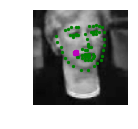

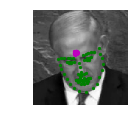

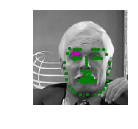

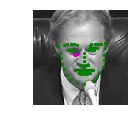

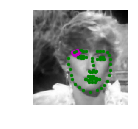

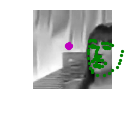

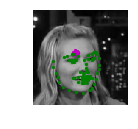

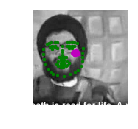

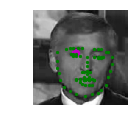

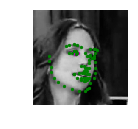

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

In [13]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2)

In [14]:
net.parameters

<bound method Module.parameters of Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (act1): ReLU()
  (maxPool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (act2): ReLU()
  (maxPool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=136, bias=True)
)>

In [24]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)
            #print(key_pts.shape)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)
            #print(output_pts.shape)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [28]:
# train your network
n_epochs = 5 

train_net(n_epochs)

/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/

Epoch: 1, Batch: 10, Avg. Loss: 0.1912748008966446
Epoch: 1, Batch: 20, Avg. Loss: 0.19703843221068382
Epoch: 1, Batch: 30, Avg. Loss: 0.19540829509496688
Epoch: 1, Batch: 40, Avg. Loss: 0.31012936383485795
Epoch: 1, Batch: 50, Avg. Loss: 0.15747193321585656
Epoch: 1, Batch: 60, Avg. Loss: 0.1744280345737934
Epoch: 1, Batch: 70, Avg. Loss: 0.17282063737511635
Epoch: 1, Batch: 80, Avg. Loss: 0.1887114718556404
Epoch: 1, Batch: 90, Avg. Loss: 0.20634603053331374
Epoch: 1, Batch: 100, Avg. Loss: 0.1595572680234909
Epoch: 1, Batch: 110, Avg. Loss: 0.18451323509216308
Epoch: 1, Batch: 120, Avg. Loss: 0.23049261718988417
Epoch: 1, Batch: 130, Avg. Loss: 0.17028379589319229
Epoch: 1, Batch: 140, Avg. Loss: 0.2759358465671539
Epoch: 1, Batch: 150, Avg. Loss: 0.16810163706541062
Epoch: 1, Batch: 160, Avg. Loss: 0.20496031492948533
Epoch: 1, Batch: 170, Avg. Loss: 0.1760728783905506
Epoch: 1, Batch: 180, Avg. Loss: 0.191466760635376
Epoch: 1, Batch: 190, Avg. Loss: 0.15741219744086266
Epoch: 1, 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.20357854589819907
Epoch: 2, Batch: 20, Avg. Loss: 0.18698104098439217
Epoch: 2, Batch: 30, Avg. Loss: 0.17165696993470192
Epoch: 2, Batch: 40, Avg. Loss: 0.17403488010168075
Epoch: 2, Batch: 50, Avg. Loss: 0.15967969000339508
Epoch: 2, Batch: 60, Avg. Loss: 0.17833830118179322
Epoch: 2, Batch: 70, Avg. Loss: 0.15179413855075835
Epoch: 2, Batch: 80, Avg. Loss: 0.16037134528160096
Epoch: 2, Batch: 90, Avg. Loss: 0.18160779029130936
Epoch: 2, Batch: 100, Avg. Loss: 0.20689035803079606
Epoch: 2, Batch: 110, Avg. Loss: 0.16523928046226502
Epoch: 2, Batch: 120, Avg. Loss: 0.1872086778283119
Epoch: 2, Batch: 130, Avg. Loss: 0.1492748200893402
Epoch: 2, Batch: 140, Avg. Loss: 0.20755599066615105
Epoch: 2, Batch: 150, Avg. Loss: 0.17136674299836158
Epoch: 2, Batch: 160, Avg. Loss: 0.16816375255584717
Epoch: 2, Batch: 170, Avg. Loss: 0.1761355333030224
Epoch: 2, Batch: 180, Avg. Loss: 0.17150498181581497
Epoch: 2, Batch: 190, Avg. Loss: 0.18236122503876687
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.17841313406825066
Epoch: 3, Batch: 20, Avg. Loss: 0.15181872099637986
Epoch: 3, Batch: 30, Avg. Loss: 0.2149982526898384
Epoch: 3, Batch: 40, Avg. Loss: 0.2004857614636421
Epoch: 3, Batch: 50, Avg. Loss: 0.19579415321350097
Epoch: 3, Batch: 60, Avg. Loss: 0.16620297133922576
Epoch: 3, Batch: 70, Avg. Loss: 0.20329617112874984
Epoch: 3, Batch: 80, Avg. Loss: 0.2567818097770214
Epoch: 3, Batch: 90, Avg. Loss: 0.18085971847176552
Epoch: 3, Batch: 100, Avg. Loss: 0.1688367061316967
Epoch: 3, Batch: 110, Avg. Loss: 0.1865176737308502
Epoch: 3, Batch: 120, Avg. Loss: 0.22386810109019278
Epoch: 3, Batch: 130, Avg. Loss: 0.14169579818844796
Epoch: 3, Batch: 140, Avg. Loss: 0.18995276615023612
Epoch: 3, Batch: 150, Avg. Loss: 0.17836577594280242
Epoch: 3, Batch: 160, Avg. Loss: 0.18884730637073516
Epoch: 3, Batch: 170, Avg. Loss: 0.14966120719909667
Epoch: 3, Batch: 180, Avg. Loss: 0.16967543065547944
Epoch: 3, Batch: 190, Avg. Loss: 0.24130043908953666
Epoch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.18532704636454583
Epoch: 4, Batch: 20, Avg. Loss: 0.19012046307325364
Epoch: 4, Batch: 30, Avg. Loss: 0.17214449048042296
Epoch: 4, Batch: 40, Avg. Loss: 0.15291235744953155
Epoch: 4, Batch: 50, Avg. Loss: 0.15177860856056213
Epoch: 4, Batch: 60, Avg. Loss: 0.16296436116099358
Epoch: 4, Batch: 70, Avg. Loss: 0.1613006256520748
Epoch: 4, Batch: 80, Avg. Loss: 0.17158957794308663
Epoch: 4, Batch: 90, Avg. Loss: 0.18765251860022544
Epoch: 4, Batch: 100, Avg. Loss: 0.15999329164624215
Epoch: 4, Batch: 110, Avg. Loss: 0.18912458419799805
Epoch: 4, Batch: 120, Avg. Loss: 0.16857827976346015
Epoch: 4, Batch: 130, Avg. Loss: 0.18514692634344102
Epoch: 4, Batch: 140, Avg. Loss: 0.20324927419424058
Epoch: 4, Batch: 150, Avg. Loss: 0.1997091718018055
Epoch: 4, Batch: 160, Avg. Loss: 0.1691841021180153
Epoch: 4, Batch: 170, Avg. Loss: 0.18742160871624947
Epoch: 4, Batch: 180, Avg. Loss: 0.16529323160648346
Epoch: 4, Batch: 190, Avg. Loss: 0.2098279669880867
Epoch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.19809871912002563
Epoch: 5, Batch: 20, Avg. Loss: 0.20708563625812532
Epoch: 5, Batch: 30, Avg. Loss: 0.18216152265667915
Epoch: 5, Batch: 40, Avg. Loss: 0.1811274379491806
Epoch: 5, Batch: 50, Avg. Loss: 0.19593722149729728
Epoch: 5, Batch: 60, Avg. Loss: 0.16818348169326783
Epoch: 5, Batch: 70, Avg. Loss: 0.152811698615551
Epoch: 5, Batch: 80, Avg. Loss: 0.19341240972280502
Epoch: 5, Batch: 90, Avg. Loss: 0.20641204863786697
Epoch: 5, Batch: 100, Avg. Loss: 0.19570660293102266
Epoch: 5, Batch: 110, Avg. Loss: 0.16779360994696618
Epoch: 5, Batch: 120, Avg. Loss: 0.14846516102552415
Epoch: 5, Batch: 130, Avg. Loss: 0.3103028014302254
Epoch: 5, Batch: 140, Avg. Loss: 0.20641340911388398
Epoch: 5, Batch: 150, Avg. Loss: 0.18064474388957025
Epoch: 5, Batch: 160, Avg. Loss: 0.1697109930217266
Epoch: 5, Batch: 170, Avg. Loss: 0.15548400580883026
Epoch: 5, Batch: 180, Avg. Loss: 0.18546565771102905
Epoch: 5, Batch: 190, Avg. Loss: 0.1876098968088627
Epoch: 5

In [25]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/

iteration 0
torch.Size([10, 136])
torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


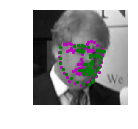

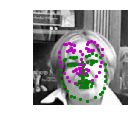

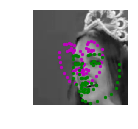

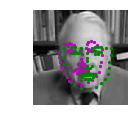

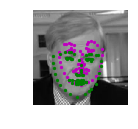

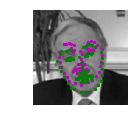

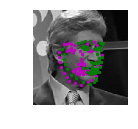

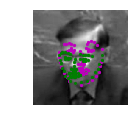

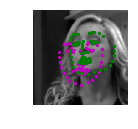

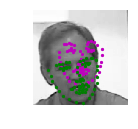

In [29]:


visualize_output(test_images, test_outputs, gt_pts)


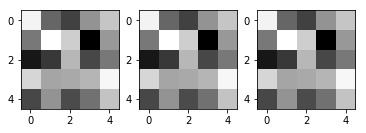

In [75]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 1

#print(w[filter_index][0])
#print(w[filter_index][0].shape)

# display the filter weights
#w[filter_index][0].shape
plt.subplot(131)
plt.imshow(w[filter_index][0], cmap='gray')
plt.subplot(132)
plt.imshow(w[filter_index][0], cmap='gray')
plt.subplot(133)
plt.imshow(w[filter_index][0], cmap='gray')


In [63]:
import cv2

/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/

iteration 0
torch.Size([10, 136])


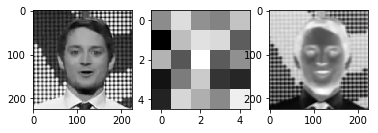

In [78]:
test_images, test_outputs, gt_pts = net_sample_output()

image = test_images[1].data   # get the image from it's Variable wrapper
image = image.numpy()   # convert to numpy array from a Tensor

weights1 = net.conv1.weight.data
w = weights1.numpy()
filter_index = 5


image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
weights_filter = np.transpose(w[filter_index], (1,2,0))

image_plot = image[:,:,0]
weights_filter_plot = weights_filter[:,:,0]

filtered_image = cv2.filter2D(image_plot, ddepth=-1, kernel= weights_filter_plot)

plt.subplot(131)
plt.imshow(image_plot, cmap='gray')
plt.subplot(132)
plt.imshow(weights_filter_plot, cmap='gray')
plt.subplot(133)
plt.imshow(filtered_image, cmap='gray')